<h1> Meat-Free Kebab Location Report</h1>

<h2>Section 1 - Introduction</h2>

Berlin is known as one of the vegan food capitals of the world, with nearly any kind of food available in meat-free variants.  However, like many German cities, it also has an obsession with Döner Kebabs.  This represents a unique business opportunity that has been largely unexplored.  At present there are very few entirely meat-free kebab shops in Berlin.  Those that do exist cater largely to the vegan, vegetarian, and environmentally conscious markets.  There is an untapped market however.  

The late-night customer often leaves a social event in the late evening or early hours of the morning seeking greasy salty food to sate their hunger.  Often tired and inebriated, this customer wants fast and friendly service with a minimum of frills.  Current meat-free kebab offerings can provide some of these, but are not typically open late enough to take advantage of this customer base.

The business problem at hand is to identify the optimal areas of Berlin to open a late-night meat-free kebab shop.  This is potentially interesting to owners of current vegan restaurants/cafes, looking to expand into the late-night market.  It is also potentially interesting to owners of late-night fast food outlets looking to attract customers who do not eat meat.

<h3>The Problem Specifics</h3>

A good area to open a meat-free kebab shop is one that fulfils the following criteria.
- An area with lots of late-night establishments such as bars or clubs, as these are our target customer base
- An area where late-night fast food places already exist, as these will have good footfall

There is also a question of whether to place the meat-free kebab shop near other vegan, vegetarian, or meat-free food outlets.  This may help with attracting customers, but if the location is far from bars or clubs then it will hurt footfall.  So there are three questions.

    1) What areas of Berlin have a high number of both late-night drinking venues and kebab outlets?
    2) Are these areas overlapping with areas with high numbers of vegan (etc.) venues?
    3) What is the optimal area(s) to open a meat-free döner kebab shop in Berlin?

<h2>Section 2 - Data</h2>

<h3>Data Sources</h3>

Firstly, location data will be acquired using the Wikipedia library for Python.  This will obtain a list of all areas in Berlin, and then use this to access the coordinates of these areas.

Secondly, the venue data for bars and kebab shops will be acquired using the FourSquare API.  This will use the coordinates from the location data to search for venues in each region of Berlin.  The venue data for vegan and vegetarian venues will use a list from HappyCow, which will then be input into FourSquare to get the location data.
The total venue data will be refined into the categories of interest to generate regional information.

<h3>Data Analysis</h3>

Exploratory analysis will be carried out to plot all the venues fitting one of our three categories (<code>bars</code>,<code>kebabs</code>,<code>vegan</code>) in Berlin.  This will give us an idea of the distribution of these venues.

Correlations will be performed to see if areas with higher numbers of each category also have higher numbers of the other category.  This will allow us to see any linear relationships between the venue categories.

Then, clusters of similar areas will be generated using k-means clustering.  This will find areas that are similar and areas that are dissimilar.  Using our critera we can then suggest what areas of Berlin are optimal in which to open a meat-free kebab shop.

<h3>Example Location Data</h3>

In [1]:
import wikipedia
BM_lat = float(wikipedia.WikipediaPage(title = 'Berlin-Mitte').coordinates[0])
BM_long = float(wikipedia.WikipediaPage(title = 'Berlin-Mitte').coordinates[1])
print('Area of Berlin: {}, Latitude: {}, Longitude: {}'.format('Berlin-Mitte',BM_lat,BM_long))

Area of Berlin: Berlin-Mitte, Latitude: 52.51944444, Longitude: 13.40666667


<h3>Example Venue Data</h3>

In [2]:
import pandas as pd
BM_df = pd.DataFrame({'Region':['Kreuzberg','Wedding'],'Venue':['Harun''s Kebab','Imrun Grill'],'Latitude':[52.4874,52.3300],'Longitude':[13.3833,13.2200],'Category':['Kebab Restaurant','Turkish Restaurant']})
BM_df

,Region,Venue,Latitude,Longitude,Category
0,Kreuzberg,Haruns Kebab,52.4874,13.3833,Kebab Restaurant
1,Wedding,Imrun Grill,52.3300,13.2200,Turkish Restaurant


<h2>Section 3 - Methodology</h2>

The following steps will be performed

    1) Import relevant modules, libraries etc.
    2) Scrape Wikipedia for location data
        a) Collect Berlin regions
        b) Data wrangling
        c) Collect Berlin region coordinates
    3) Use location data to call Foursquare API
        a) Assemble API calling function
        b) Run through regions to collect venue data
    4) Use the HappyCow database to find venues
        a) Read the HappyCow Database
        b) Use GeoPy to add these to the venues dataframe
    5) Data wrangling
    6) Visualisation of venue data
    7) Correlation of region data
    8) Clustering of regions

<h3>3.1 Importing libraries</h3>

In [3]:
import wikipedia
import pandas as pd
import numpy as np
import requests
import folium
import geopy
from lxml import html
from geopy.geocoders import Nominatim

<h3>3.2 Scrape Wikipedia for location data</h3>

The first step is to grab a list of the localities of Berlin.  We can source this from https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin.

In [10]:
table_range = np.arange(2,13+1) #this is the table numbers in the wikipedia page we want
all_localities = pd.DataFrame()
for t in table_range:
    this_table = pd.read_html('https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin', header = 0)[t]
    all_localities = all_localities.append(this_table,ignore_index = True)
localities = all_localities
localities.head()

,Locality,Area in km²,Population as of 2008,Density inhabitants per km²,Map
0,(0101) Mitte,10.70,79582,7445,NaN
1,(0102) Moabit,7.72,69425,8993,NaN
2,(0103) Hansaviertel,0.53,5889,11111,NaN
3,(0104) Tiergarten,5.17,12486,2415,NaN
4,(0105) Wedding,9.23,76363,8273,NaN


Now we have our list of all the localities in Berlin, we need to do some data wrangling to make this prettier.  We will remove all non-useful columns so that we are just left with a list of the names of the localities.  Then we need to get rid of the postal codes that prefix each of them, as we do not need this information.

In [12]:
#remove unneeded columns
localities.drop(columns=['Area in km²','Population as of 2008','Density inhabitants per km²','Map'],inplace=True)

for i in np.arange(localities.shape[0]): #iterate through all rows in the table
    #split the string after the closing parenthesis and just keep the name
    localities['Locality'][i] = localities['Locality'][i].split(') ')[1]
    
localities.head(10)

,Locality
0,Mitte
1,Moabit
2,Hansaviertel
3,Tiergarten
4,Wedding
5,Gesundbrunnen
6,Friedrichshain
7,Kreuzberg
8,Prenzlauer Berg
9,Weißensee


Our next step in this is to use this list of localities to get coordinate data from wikipedia.  We can do this using the wikipedia library.  We will sequentially input each name in the locality dataframe, get the coordinates, and then place them into our dataframe.

One thing to be aware of though, is that calling wikipedia coordinates provides a number in Decimal Degrees.  This is fine as FourSquare takes decimal degrees as input, but be aware that these latitude and longitude pairs may look odd because of this.

We need to append <code>(Berlin)</code> to some locality names, as some will not lead to the appropriate page on wikipedia.  For example Wedding will lead to a page on the marriage ceremony, not to the locality in Berlin-Mitte. Below the code checks to see if there are coordinates avaiable for the normal name.  If not, then it appends <code>(Berlin)</code> and sends another request.  The name in the localities dataframe is also updated.

In [13]:
lat_long_df = pd.DataFrame(columns = ['Latitude','Longitude'])

for i in np.arange(localities.shape[0]):
    
    #find coordinate data, or change name then find coordinate data
    try:
        lat_long = wikipedia.WikipediaPage(title = localities['Locality'][i]).coordinates
    except:
        localities['Locality'][i] = localities['Locality'][i]+' (Berlin)'
        lat_long = wikipedia.WikipediaPage(title = localities['Locality'][i]).coordinates
    
    #convert to float and add to dataframe
    this_lat = float(lat_long[0])
    this_long = float(lat_long[1])
    lat_long_df.loc[i,:] = [this_lat,this_long]
    
lat_long_df.head()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


,Latitude,Longitude
0,52.5167,13.3667
1,52.5333,13.3333
2,52.5167,13.3389
3,52.5167,13.3667
4,52.55,13.3667


Furthermore, some localities share a name with their parent borough.  So, we need to rename all of these with <code>(locality)</code> to get the correct coordinates.

In [18]:
boroughs = pd.read_html('https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin', header = 0)[0]
wrong_name = localities.index[localities['Locality'].isin(boroughs['Borough'])].tolist()

for w in wrong_name:
    localities['Locality'][w] = localities['Locality'][w]+' (locality)'
    lat_long = wikipedia.WikipediaPage(title = localities['Locality'][w]).coordinates
    this_lat = float(lat_long[0]); this_long = float(lat_long[1])
    lat_long_df.loc[w,:] = [this_lat,this_long]

Then we need to add these columns onto our localities dataframe, to create one unified dataframe with all our location data in it.

In [19]:
location_df = pd.concat([localities, lat_long_df], axis=1, sort=False)
location_df.head()

,Locality,Latitude,Longitude
0,Mitte (locality),52.5194,13.4067
1,Moabit,52.5333,13.3333
2,Hansaviertel,52.5167,13.3389
3,Tiergarten (Berlin),52.5167,13.3667
4,Wedding (Berlin),52.55,13.3667


Now we will check that all of our coordinates are correct!  Any that are not will need to be re-entered

In [20]:
germany_map = folium.Map(location = [51.25,9.5],zoom_start=5)

for lat, long, name in zip(location_df['Latitude'],location_df['Longitude'],location_df['Locality']):
    label = folium.Popup(str(name))
    folium.CircleMarker([lat, long], radius = 2, popup=label).add_to(germany_map)

germany_map

We can see that four of our coordinate pairs are in incorrect positions.  From the popups on our Folium map we can see that these are <code>Falkenburg</code>,<code>Malchow</code>,<code>Buckow</code>, and <code>Biesdorf</code>.  We will therefore alter the names in the location dataframe for these, find their correct coordinates, and correct our dataframe.

In [21]:
wrong_coords = location_df.index[location_df['Locality'].isin(['Falkenberg','Malchow','Buckow','Biesdorf'])].tolist()

for w in wrong_coords:
    location_df['Locality'][w] = location_df['Locality'][w] + ' (Berlin)'
    lat_long = wikipedia.WikipediaPage(title = location_df['Locality'][w]).coordinates
    location_df['Latitude'][w] = float(lat_long[0])
    location_df['Longitude'][w] = float(lat_long[1])  

And then we can double check that this has worked properly by reshowing our map and making sure that all the markers are in Berlin now.

In [22]:
germany_map = folium.Map(location = [51.25,9.5],zoom_start=5)

for lat, long, name in zip(location_df['Latitude'],location_df['Longitude'],location_df['Locality']):
    label = folium.Popup(str(name))
    folium.CircleMarker([lat, long], radius = 2, popup=label).add_to(germany_map)

germany_map

All of our markers are in the right place, so we can be confident that we have done this correctly now.

<h3>3.3 - Using the FourSquare API to find Venues</h3>

We need to use our coordinate data to make calls to FourSquare, so we need to first assemble our calling function.  We start with importing the Client ID and Client Secret strings.  For privacy these will be imported from text files stored on my system, rather than being hardcoded into the notebook

In [23]:
with open ("ID.txt", "r") as myfile:
    CLIENT_ID=myfile.read().replace('\n', '')

with open ("SECRET.txt", "r") as myfile:
    CLIENT_SECRET=myfile.read().replace('\n', '')

VERSION = '20190910' # Foursquare API version
print('Client ID and Client Secret have been entered.  The Version is {}.'.format(VERSION))

Client ID and Client Secret have been entered.  The Version is 20190910.


Now that we have these, we can make our API calling function for the kebab and bar venues.  This will take in arguments we give it about the coordinates to look at, and output a dataframe that contains information about the venues in this area.

In [30]:
def getVenues(locality,latitude,longitude,query_list):
    radius = 750; limit = 100
    
    cl = ['Locality','LocLat','LocLong','Venue','Latitude','Longitude','Category']
    all_venues = pd.DataFrame(columns = cl)
    for name, lat, long in zip(locality,latitude,longitude):
        
        for query in query_list:
            
            #generate URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&intent={}&radius={}&limit={}&query={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                long, 
                'browse',
                radius, 
                limit,
                query)
            
            # the output of the search query
            output = requests.get(url).json()['response']
            if len(output) != 0: #avoids situations where nothing is found

                for v in np.arange(len(output['venues'])):

                    if len(output['venues'][v]['categories']) != 0: # avoids odd venues with no category
                        new_venues = pd.DataFrame([[
                            name,                                              #locality
                            lat,                                               #locality lat
                            long,                                              #locality long
                            output['venues'][v]['name'],                       #venue name
                            output['venues'][v]['location']['lat'],            #venue latitude
                            output['venues'][v]['location']['lng'],            #venue longitude
                            output['venues'][v]['categories'][0]['shortName']  #venue category
                        ]],columns = cl)
                        all_venues = all_venues.append(new_venues,ignore_index = True)              

    return(all_venues)              

Before we can run our program, we need to determine what the query terms should be.  The below have been chosen to give a good representation of the venues we are interested in.

In [27]:
query_list = ['Kebab','Doner','Bar','Nightclub','Brewery']

Now we can finally run our API calling function.  This may take some time!

In [32]:
venues_list = getVenues(location_df['Locality'],location_df['Latitude'],location_df['Longitude'],query_list)
venues_list.head()

,Locality,LocLat,LocLong,Venue,Latitude,Longitude,Category
0,Mitte (locality),52.519444,13.406667,Dado Krauti & Kebab Berlin,52.520095,13.402043,Burritos
1,Mitte (locality),52.519444,13.406667,Doner Kebab Linden-Grill,52.520005,13.404954,Doner
2,Mitte (locality),52.519444,13.406667,Gemüse Kebab,52.521797,13.410614,Falafel
3,Mitte (locality),52.519444,13.406667,Pergamon Döner & Pizza,52.520953,13.411929,Doner
4,Mitte (locality),52.519444,13.406667,Alex Döner & Pizza,52.520720,13.411666,Doner


Let's quickly take a look at the dataframe we got out.

In [33]:
venues_list.shape

(657, 7)

In [34]:
venues_list.describe(include='all')

,Locality,LocLat,LocLong,Venue,Latitude,Longitude,Category
count,657,657.000000,657.000000,657,657.000000,657.000000,657
unique,72,NaN,NaN,558,NaN,NaN,128
top,Mitte (locality),NaN,NaN,Balli Döner,NaN,NaN,Doner
freq,63,NaN,NaN,6,NaN,NaN,133
mean,NaN,52.510255,13.394007,NaN,52.510063,13.393646,NaN
std,NaN,0.040286,0.075994,NaN,0.039961,0.075682,NaN
min,NaN,52.400000,13.142778,NaN,52.395707,13.142212,NaN
25%,NaN,52.481389,13.333333,NaN,52.481957,13.334595,NaN
50%,NaN,52.515833,13.403333,NaN,52.512613,13.400565,NaN
75%,NaN,52.539167,13.435278,NaN,52.535136,13.437811,NaN


It is possible that we have gotten some false results however.  For instance <code>Barbara's Hair Salon</code> would appear under the search query <code>Bar</code>, but it is clearly not what we are looking for!

In [35]:
venues_list['Category'].unique()

array(['Burritos', 'Doner', 'Falafel', 'Cocktail', 'Hotel Bar', 'Diner',
       'Wine Bar', 'Bar', 'Snacks', 'Tea Room', 'Pub', 'Nail Salon',
       'Karaoke', 'Restaurant', 'Club', 'BBQ', 'Cosmetics', 'Juice Bar',
       'Café', 'Spanish', 'Health & Beauty', 'Boat / Ferry',
       'Coffee Shop', 'Tapas', 'Gay Bar', 'Italian', 'Wine Shop',
       'Advertising Agency', 'Billiards', 'Turkish', 'Asian',
       'Hookah Bar', 'Spa', 'Music School', 'Medical', 'Bakery', 'Kebab',
       'Mediterranean', "Dentist's Office", 'Road',
       'Corporate Coffee Shop', 'Middle Eastern', 'Shop',
       'Salon / Barbershop', 'Music Venue', 'Dive Bar', 'Lounge',
       'Playground', 'Insurance Office', 'Pizza', 'Sushi', 'Food Truck',
       'Fast Food', 'Sports Bar', 'Strip Club', 'Art Gallery',
       "Farmer's Market", 'Japanese', 'Toys & Games', 'Smoke Shop',
       'German', 'Sandwiches', 'Breakfast', 'Beer Bar', 'French',
       'Korean', 'Vietnamese', 'Tiki Bar', 'Tattoo', 'Burgers', 'Indian',
  

So we will remove any results that are not what we want.  The easiest way to do this is just to specify the categories that can stay.  We will sort these into food and bars.

In [36]:
food_cats = [ 'Burritos','Doner','Falafel','Turkish','Kebab','Middle Eastern']
bar_cats = ['Cocktail','Wine Bar','Bar','Pub','Club','Gay Bar','Dive Bar','Beer Bar','Tiki Bar','Nightclub','Beer Garden',
           'Brewery','Speakeasy']

In [37]:
corr_venues = venues_list[(venues_list['Category'].isin(food_cats) | venues_list['Category'].isin(bar_cats))]
corr_venues.head()

,Locality,LocLat,LocLong,Venue,Latitude,Longitude,Category
0,Mitte (locality),52.519444,13.406667,Dado Krauti & Kebab Berlin,52.520095,13.402043,Burritos
1,Mitte (locality),52.519444,13.406667,Doner Kebab Linden-Grill,52.520005,13.404954,Doner
2,Mitte (locality),52.519444,13.406667,Gemüse Kebab,52.521797,13.410614,Falafel
3,Mitte (locality),52.519444,13.406667,Pergamon Döner & Pizza,52.520953,13.411929,Doner
4,Mitte (locality),52.519444,13.406667,Alex Döner & Pizza,52.520720,13.411666,Doner


<h3>3.4 - Using the HappyCow Database to find Vegan and Vegetarian venues</h3>

Unfortunately using FourSquare very few vegan/vegetarian venues can be found easily.  However there is an alternative through the use of HappyCow.  The below URL leads to a printable page listing all venues which offer solely vegan and/or vegetarian food, within 15 miles of the centre of Berlin.  

The code below turns this into a readable text file which we can then process further

In [48]:
# the below method uses the search results and reads them in

def getHappyCow():
    veg_link = 'https://www.happycow.net/searchmap/print?location=berlin&filters=vegan-vegetarian&radius=15&metric=mi&limit=81&order=default&lat=52.52&lng=13.405'

    page = requests.get(veg_link)
    tree = html.fromstring(page.content)

    #solution from https://stackoverflow.com/q/328356/
    import urllib
    from bs4 import BeautifulSoup

    html = urllib.request.urlopen(veg_link).read()
    soup = BeautifulSoup(html)

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out

    # get text
    text = soup.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    
    return text

In [332]:
# this method reads in a saved version of the search instead, to avoid busing HappyCow's website

import codecs
t = codecs.open('HC_results.txt','r','utf-8')
text = t.read()
print(text[0:1000])

Vedang plant burger - Alexa Mall (Vegan) 0.5 mi
Grunerstr. 20, Berlin, Germany, 10179 - Telephone: +49-3021454713
Ryong (Vegetarian) 0.65 mi
Torstr. 59, Berlin, Germany, 10119 - Telephone: +49-3030307047
Jivamukti Canteen (Vegan) 1.04 mi
Brunnenstr. 29, Berlin, Germany, 10119 - Telephone: +49-3048491948
Vedang plant burger - Mall of Berlin (Vegan) 1.28 mi
Leipziger Platz 12, Berlin, Germany, 10117 - Telephone: +49-3022002727
Cafe Canna (Vegan) 1.52 mi
Lychener Straße 4, Berlin, Germany, 10437 - Telephone: +49-1777883507
Brammibal's Donuts - Danziger (Vegan) 1.53 mi
Danziger Strasse 65, Berlin, Germany, 10435 - Telephone: +49-3053056524
Brammibal's Donuts - Potsdamer Platz (Vegan) 1.56 mi
Alte Potsdamer Straße 7, Berlin, Germany, 10785 - Telephone: +49-3023321592
Brammibal's Donuts - Maybachufer (Vegan) 1.9 mi
Maybachufer 8, Berlin, Germany, 12047 - Telephone: +49-3023948455
EmmaPea Vegan Food and Bar (Vegan) 2.26 mi
Revaler Strasse 99, Berlin, Germany, 10245 - Telephone: +49-1636882940

Then we will split the text from alternating lines of names and addresses, to two lists - one for each.

In [333]:
def splitter(seq):
    return seq[::2], seq[1::2]

split_text = text.splitlines() #converts to a list split by line
veg_name,veg_address = splitter(split_text)

And at this point we will drop the telephone number and any parentheses, to just give us a searchable address.

In [334]:
for v in np.arange(len(veg_address)):
    veg_address[v] = veg_address[v].split(', Germany,')[0].split(' - ')[0]
    if len(veg_address[v].split(' ('))>1:
        veg_address[v] = veg_address[v].split(' (')[0]+', Berlin'

veg_address[0:5]

['Grunerstr. 20, Berlin',
 'Torstr. 59, Berlin',
 'Brunnenstr. 29, Berlin',
 'Leipziger Platz 12, Berlin',
 'Lychener Straße 4, Berlin']

And run a similar process to remove the tags in the names of the venues.

In [335]:
for v in np.arange(len(veg_name)):
    veg_name[v] = veg_name[v].split(' (')[0]
    
veg_name[0:5]

['Vedang plant burger - Alexa Mall',
 'Ryong',
 'Jivamukti Canteen',
 'Vedang plant burger - Mall of Berlin',
 'Cafe Canna']

Now that we have this, we can get the location data from the addresses.

In [338]:
cl = ['Locality','LocLat','LocLong','Venue','Latitude','Longitude','Category']
all_veg_venues = pd.DataFrame(columns = cl)
geolocator = Nominatim(user_agent="IBM Capstone 2")

#solution from https://gis.stackexchange.com/q/173569/
from geopy.exc import GeocoderTimedOut
def do_geocode(address):
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)
# end solution

for n in np.arange(len(veg_name)):
    
    location = do_geocode(veg_address[n])
    
    new_veg_venue = pd.DataFrame([[
        'Unknown',
        'UnknownLat',
        'UnknownLong',
        veg_name[n],
        location.latitude,
        location.longitude,
        'Vegan/Vegetarian'
    ]],columns = cl)
    
    all_veg_venues = all_veg_venues.append(new_veg_venue,ignore_index = True)
    
all_veg_venues.head()

,Locality,LocLat,LocLong,Venue,Latitude,Longitude,Category
0,Unknown,UnknownLat,UnknownLong,Vedang plant burger - Alexa Mall,52.519072,13.416015,Vegan/Vegetarian
1,Unknown,UnknownLat,UnknownLong,Ryong,52.529096,13.408894,Vegan/Vegetarian
2,Unknown,UnknownLat,UnknownLong,Jivamukti Canteen,52.534511,13.398472,Vegan/Vegetarian
3,Unknown,UnknownLat,UnknownLong,Vedang plant burger - Mall of Berlin,52.509976,13.380821,Vegan/Vegetarian
4,Unknown,UnknownLat,UnknownLong,Cafe Canna,52.541112,13.414850,Vegan/Vegetarian


Then we need to find which region is closest to each veg venue, so that we can cluster them later on.  We will take a simple approach to this by finding the closest in real distance and taking that as the correct region.

In [339]:
import geopy.distance as gdd

In [340]:
for ven in np.arange(len(all_veg_venues)):
    
    distances = []
    for loc in np.arange(len(location_df)):
        coords_ven = [all_veg_venues['Latitude'][ven],all_veg_venues['Longitude'][ven]]
        coords_loc = [location_df['Latitude'][loc],location_df['Longitude'][loc]]
        dist = gdd.distance(coords_ven,coords_loc)
        distances.append(dist)
    
    min_dist = distances.index(min(distances))
    all_veg_venues['Locality'][ven] = location_df['Locality'][min_dist]
    all_veg_venues['LocLat'][ven] = location_df['Latitude'][min_dist]
    all_veg_venues['LocLong'][ven] = location_df['Longitude'][min_dist]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pa

In [341]:
all_veg_venues.head()

,Locality,LocLat,LocLong,Venue,Latitude,Longitude,Category
0,Mitte (locality),52.5194,13.4067,Vedang plant burger - Alexa Mall,52.519072,13.416015,Vegan/Vegetarian
1,Mitte (locality),52.5194,13.4067,Ryong,52.529096,13.408894,Vegan/Vegetarian
2,Gesundbrunnen (Berlin),52.5486,13.3903,Jivamukti Canteen,52.534511,13.398472,Vegan/Vegetarian
3,Tiergarten (Berlin),52.5167,13.3667,Vedang plant burger - Mall of Berlin,52.509976,13.380821,Vegan/Vegetarian
4,Prenzlauer Berg,52.5392,13.4242,Cafe Canna,52.541112,13.414850,Vegan/Vegetarian


And then we simply need to join these two dataframes together to have all of our venues, ready for further processing.

In [342]:
venues_df =  pd.concat([corr_venues, all_veg_venues], axis=0, sort=False)
venues_df = venues_df.reset_index(drop=True)
venues_df.head()

,Locality,LocLat,LocLong,Venue,Latitude,Longitude,Category
0,Mitte (locality),52.5194,13.4067,Dado Krauti & Kebab Berlin,52.520095,13.402043,Burritos
1,Mitte (locality),52.5194,13.4067,Doner Kebab Linden-Grill,52.520005,13.404954,Doner
2,Mitte (locality),52.5194,13.4067,Gemüse Kebab,52.521797,13.410614,Falafel
3,Mitte (locality),52.5194,13.4067,Pergamon Döner & Pizza,52.520953,13.411929,Doner
4,Mitte (locality),52.5194,13.4067,Alex Döner & Pizza,52.520720,13.411666,Doner


<h3>3.5 Data Wrangling</h3>

In this section we will sort our data into the appropriate groups ready for processing.

In [343]:
VenueType = []
for i in np.arange(len(venues_df)):
    if venues_df['Category'][i] in food_cats:
        VenueType.append('Kebab')
    elif venues_df['Category'][i] in bar_cats:
        VenueType.append('Bar')
    else:
        VenueType.append('Vegan')

In [344]:
venues_df['VenueType'] = VenueType
venues_df.head()

,Locality,LocLat,LocLong,Venue,Latitude,Longitude,Category,VenueType
0,Mitte (locality),52.5194,13.4067,Dado Krauti & Kebab Berlin,52.520095,13.402043,Burritos,Kebab
1,Mitte (locality),52.5194,13.4067,Doner Kebab Linden-Grill,52.520005,13.404954,Doner,Kebab
2,Mitte (locality),52.5194,13.4067,Gemüse Kebab,52.521797,13.410614,Falafel,Kebab
3,Mitte (locality),52.5194,13.4067,Pergamon Döner & Pizza,52.520953,13.411929,Doner,Kebab
4,Mitte (locality),52.5194,13.4067,Alex Döner & Pizza,52.520720,13.411666,Doner,Kebab


Now that we have our venues sorted into the three categories of interest, we will need to create dummy variables so that we can run cluster analysis.

In [345]:
dums = pd.get_dummies(venues_df['VenueType'])
venues_df[['isBar','isKebab','isVegan']] = dums
venues_df.head()

,Locality,LocLat,LocLong,Venue,Latitude,Longitude,Category,VenueType,isBar,isKebab,isVegan
0,Mitte (locality),52.5194,13.4067,Dado Krauti & Kebab Berlin,52.520095,13.402043,Burritos,Kebab,0,1,0
1,Mitte (locality),52.5194,13.4067,Doner Kebab Linden-Grill,52.520005,13.404954,Doner,Kebab,0,1,0
2,Mitte (locality),52.5194,13.4067,Gemüse Kebab,52.521797,13.410614,Falafel,Kebab,0,1,0
3,Mitte (locality),52.5194,13.4067,Pergamon Döner & Pizza,52.520953,13.411929,Doner,Kebab,0,1,0
4,Mitte (locality),52.5194,13.4067,Alex Döner & Pizza,52.520720,13.411666,Doner,Kebab,0,1,0


<h3>3.6 Visualisation of Data</h3>

Firstly, let's have a look at where the venues that we have found are located in Berlin.  We will make a simple Folium map, colour-coding each venue location by type.

In [346]:
berlinMap = folium.Map(location = [52.52,13.40],zoom_start=11)

for lat, long, vtype in zip(venues_df['Latitude'],venues_df['Longitude'],venues_df['VenueType']):
    if (vtype == 'Kebab'): 
        mColor = 'red'
    elif (vtype == 'Bar'):
        mColor = 'blue'
    else:
        mColor = 'green'
    folium.CircleMarker([lat, long], radius = 2,color = mColor).add_to(berlinMap)

berlinMap

There are definitely some clusters here!  We can in particular see that there are two areas with more veggie/vegan venues.  We can also see clusters of bars and kebab houses dotted around areas of Berlin.

<h3>3.7 Correlation of Regional Data</h3>

Here we will find the number of each venue type within each region.  We will then use these values to see if there is a correlation between any of the venue types.

In [403]:
ven_nums = venues_df.groupby(['Locality','LocLat','LocLong'])[['isBar','isKebab','isVegan']].sum().reset_index()
#ven_nums = venues_df[['Locality','isBar','isKebab','isVegan']].groupby(['Locality']).sum().reset_index()
ven_nums.head()

,Locality,LocLat,LocLong,isBar,isKebab,isVegan
0,Adlershof,52.437778,13.547500,3,1,0
1,Alt-Treptow,52.490000,13.449444,3,2,14
2,Baumschulenweg,52.465000,13.486111,2,1,0
3,Biesdorf (Berlin),52.509167,13.555278,0,1,0
4,Buch (Berlin),52.633611,13.499167,0,1,0


Firstly, we will run a correlation to find the correlation coefficents of each venue type with the others. Then we will show a grid of scatterplots for these pairings.  On the diagonal we will plot histograms of each venue type.

In [390]:
ven_nums[['isBar','isKebab','isVegan']].corr()

,isBar,isKebab,isVegan
isBar,1.000000,0.647197,0.917294
isKebab,0.647197,1.000000,0.634117
isVegan,0.917294,0.634117,1.000000


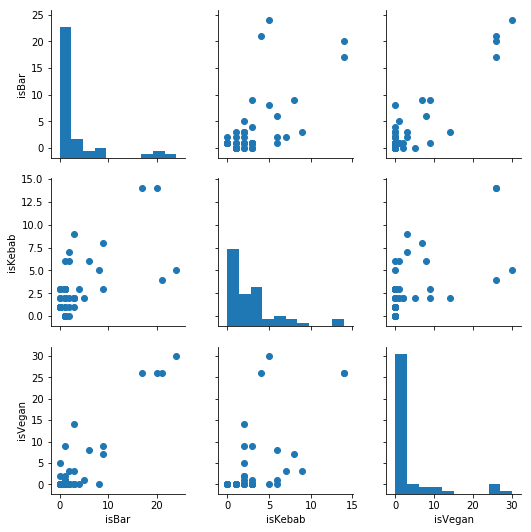

In [391]:
import seaborn as sns
import matplotlib.pyplot as plt

g=sns.PairGrid(ven_nums[['isBar','isKebab','isVegan']])

g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

So it appears that we have positive correlations between each type of venue.  This should not be completely surprising, as where there are more venues we should get more of all types of venue.  We must still test the significance of these relationships though!

In [392]:
import scipy.stats as sct
print('Bars vs Kebabs, p_value: {}'.format(sct.pearsonr(ven_nums['isBar'],ven_nums['isKebab'])[1]))
print('Bars vs Vegan, p_value: {}'.format(sct.pearsonr(ven_nums['isBar'],ven_nums['isVegan'])[1]))
print('Kebabs vs Vegan, p_value: {}'.format(sct.pearsonr(ven_nums['isKebab'],ven_nums['isVegan'])[1]))

Bars vs Kebabs, p_value: 7.047070865326194e-08
Bars vs Vegan, p_value: 2.9911789352541103e-23
Kebabs vs Vegan, p_value: 1.5472889433465623e-07


We can see that all three tests are significant, indicating that these correlations are probably not due to chance.

<h3>3.8 Clustering of Regions</h3>

Now that we have all of our data we can try to cluster the localities of Berlin by the three venue types.  We will perform this using k-Means clustering.  This allows us to use an unsupervised machine learning method, which is useful as we do not know what the 'correct' answer is.  

In [400]:
from sklearn.cluster import KMeans
ven_data = ven_nums[['isBar','isKebab','isVegan']]

One method to determine the best value of k to use is the Elbow Method.  This plots the cost for each value of k, and allows you to determine the 'elbow'.  This is the point at which the value added by increasing k decreases less dramatically for each step in k.

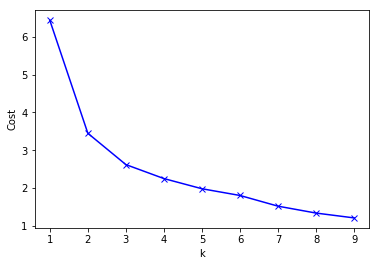

In [401]:
from scipy.spatial.distance import cdist
cost = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=5).fit(ven_data)
    cost.append(sum(np.min(cdist(ven_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / ven_data.shape[0])

plt.plot(K, cost, 'bx-')
plt.xlabel('k')
plt.ylabel('Cost')
plt.show()

Here the elbow is somewhere between 2 and 3, so we will choose 3 as our value for k.

In [404]:
k_value = 3
km_model = KMeans(n_clusters = k_value,random_state = 5)
km_model.fit(ven_data)
cluster_labels = km_model.labels_

ven_nums.insert(3,'Cluster',cluster_labels)

<h2>Section 4 - Results</h2>

We have performed k-Means classification of our data in the previous section.  Here we will look at the results and discuss what it is that we have found.

Firstly, we will look at the average amount of each type of venue within each cluster.  This will allow us to see what the 'average' region is for each cluster.

In [399]:
ven_nums.groupby(['Cluster']).mean()

,LocLat,LocLong,isBar,isKebab,isVegan
Cluster,,,,,
0,52.506856,13.404965,1.191489,2.042553,0.382979
1,52.513958,13.430069,20.500000,9.250000,27.000000
2,52.512444,13.389056,5.600000,4.200000,9.400000


From this, it would appear that we can describe our clusters as follows.

    0) Low number of all venues
    1) Many Bars and Vegan, some Kebabs
    2) Moderate number of all venues

Let's visualise our clusters on our map of Berlin.  Cluster 0 is <span style="color:red">red</span>, cluster 1 is <span style="color:green">green</span>, and cluster 2 is <span style="color:orange">orange</span>.

In [411]:
clusterMap = folium.Map(location = [52.52,13.40],zoom_start=11)
clus_col = ['red','green','orange']

for name, lat, lng, clust in zip(ven_nums['Locality'],ven_nums['LocLat'],ven_nums['LocLong'],ven_nums['Cluster']):
    label = folium.Popup(name+', cluster: '+str(clust))
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = clus_col[clust],
        fill_color = clus_col[clust],
        fill_opacity = 1).add_to(clusterMap)
clusterMap

It appears that our clusters are also arranged somewhat geographically.  Cluster 1 is mainly around central Berlin, and cluster 2 is a little further out.  Cluster 0 is mainly the outlying regions of Berlin.

<h2>Section 5 - Discussion</h2>
<h3>5.1 Answering the Questions</h3>

Our aim was to answer three questions:

    1) What areas of Berlin have a high number of both late-night drinking venues and kebab outlets?
    2) Are these areas overlapping with areas with high numbers of vegan (etc.) venues?
    3) What is the optimal area(s) to open a meat-free döner kebab shop in Berlin?

From our results we can now provide informed answers to these questions.  

Areas in clusters 1 and 2 contains large numbers of bars/other drinking venues that are open late at night, and also kebab shops.  These are primarily located around central Berlin.

These areas do have overlap with areas containing high numbers of vegan venues.  This is more true of areas in cluster 1, but there is still a moderate amount of vegan venues in areas in cluster 2.

Our results suggest that the optimal place to open a meat-free döner kebab shop in Berlin would be areas within cluster 1.  These are <code>Prenzlauer Berg</code>, <code>Mitte</code>, <code>Friedrichshain</code>, and <code>Neukölln</code>.  These areas have a high concentration of late-night drinking venues, providing a large potential customer base.  They do have some kebab shops, ensuring that there is footfall, and a high concentration of vegan venues which is evidence that consumers in these areas have an interest in meat-free alternatives.

<h3>5.2 Notes on this Analysis</h3>

<h4>Acquisition of Information on Vegan Venues</h4>

Information on vegan/vegetarian venues was sourced not from FourSquare, but from HappyCow.  This resource is a free to access crowd-sourced repository of information on venues that are solely aimed at, or offer options for, vegan and vegetarian consumers.  The choice to use this resource instead of FourSquare was based on the sparsity of information available from FourSquare.  Initial exploration provided only 4 venues on the FourSquare database that were categorised as vegan/vegetarian.  Although certainly more existed there was no easy way to determine the content of a venue's selection.

There was some complications in accessing the information from HappyCow as they do not provide an API.  Fortunately, there is a searchable website, whose output can be parsed using html-reading methods.  For ease of use and replicability (the URL not being stable), this information was preprocessed slightly.  This caused a small bottleneck in the creation of this document, but was not sufficient to counteract using more complicated means.

<h4>Variability in k-Means output</h4>

As the k-Means method by default uses random starting points, without some control the method's output is not guaranteed to be the same each time.  Furthermore, different values of *k* (the number of clusters) can generate different clusters too.  I opted to use the elbow method to provide some guidance on what value to assign to *k* here.  This suggested an elbow of between 2 and 3.  As *k* must be a positive integer, I opted for 3 as 2 seemed too low to be of informational value.  I could have reduced the distances to each cluster mean by using higher values of *k* but this would have been subject to diminishing returns and may have led to overfitting.

<h4>Knowledge of the local area</h4>

It should be pointed out that I am not German, nor have I ever been to Berlin.  The only relevant local knowledge that I had prior to this analyis was that doner kebabs are popular in Germany in general, and that Berlin has a large number of vegan restaurants.  Other than a short piece of research to determine what regionalisation is present in Berlin, I did not need to know any more information about the area to perform this method of analysis.  If you look at the maps generated the clusters are arranged very geographically.  Given that the data input had no location information whatsoever, this is just an outcome of the similarity between the localities within Berlin.

<h2>Section 6 - Conclusion</h2>

This report looked at a fictional scenario where a client seeks information on where to open a restaurant specialising in meat-free doner kebabs, in Berlin.  In order to do this, location and venue data was acquired from multiple sources to generate a profile of the localities within Berlin.  From this, clustering classification was performed to provide a suggestion as to an area or areas which would provide a large base of customers who fit the target demographic (late-night, drinking, interest in meat-free alternatives).

The results of the report suggested four areas, all within central Berlin, where the profile of venues in that locality would suggest that it would be an optimal location to open a meat-free doner kebab shop.  These areas are <code>Prenzlauer Berg</code>, <code>Mitte</code>, <code>Friedrichshain</code>, and <code>Neukölln</code>.

The analysis employed here was very successful as it produced a concrete suggestion for the client, using a wholly naive system.  A client would be able to use this information to leverage the consumer base within Berlin without requiring local knowledge.  This method could be extended to other cities or other fast-food products with relative ease.